In [1]:
%load_ext autoreload
%autoreload 2    
%matplotlib inline

In [4]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import numpy as np
import glob
from PIL import Image, ExifTags

# pip install torchsummary
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from time import time
import pandas as pd
import random

import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from matplotlib.patches import Polygon, Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (6,6)

# Own imports 
from config import * 
from utils import *
from data_loader import TacoDataset
from eval import *

# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(8);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#img_size = 512

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(10, 10, 10, p=0.3),
    A.GaussNoise(p=0.5),
    A.Normalize(), # If you want to visualize - comment this line 
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                            min_visibility=0.3, # min visibility of the original area in case of a crop
                           )
)

test_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                           )
)

In [6]:
BATCH_SIZE = 16

In [7]:
trainset = TacoDataset( 'train', transforms=train_transform, test_size=0.2) # test_transform for no augment
valset   = TacoDataset('val', transforms=test_transform, test_size=0.2)
testset  = TacoDataset('test', transforms=test_transform, test_size=0.2)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)

In [8]:
loss_function = nn.BCELoss()

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = transfer_model_set(model, freeze_convs=False)
optimizer = torch.optim.Adam(model.parameters(), HEAD_LEARNING_RATE)

lr_scheduler = None

In [9]:
NUM_EPOCHS = 10

In [10]:
for epoch in range(NUM_EPOCHS):
    model.train()
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")

    train_loss = []
    train_correct = 0
    train_len = 0
    
    for minibatch_no, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        images = [image for image, _, _ in batch]
        bboxes = [bbox for _, bbox, _ in batch]
        labels = [label for _, _, label in batch]
        
        # Selective search
                
        # Edge boxes
        cropped_images_all, proposals_all, predictions_all = edge_boxes_train(images, bboxes)         
        if len(cropped_images_all) ==0:
            print('no boxes detected')
            break 
        data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)
        
        # CNN
        optimizer.zero_grad()
        output = model(data)[:,0]
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        predicted = output > 0.5
        correct_in_the_item = (target==predicted).sum().cpu().item()
        train_correct += correct_in_the_item
        train_len += data.shape[0]
        print(f'train_loss: {loss:.5f}        Accuracy {correct_in_the_item / len(target):.3f}')
        # break
    continue
    # Test evaluation
    model.eval()
    for batch in val_loader:
        test_images = [image for image, _, _ in batch]
        test_bboxes = [bbox for _, bbox, _ in batch]
        test_labels = [label for _, _, label in batch]
        
        # Selective search
        test_cropped_images_all, test_proposals_all = selective_search_test(test_images, test_bboxes) 
        test_data = torch.stack(test_cropped_images_all).to(device)
        
        with torch.no_grad():
            outputs = model(test_data)[:,0]
        predicted = (outputs > 0.5).tolist()
        
        # Reshaping
        outputs = outputs.tolist()
        new_shape = [len(l) for l in test_proposals_all]
        output_new_shape, predicted_new_shape = [], []
        head = 0
        for l in new_shape:
            output_new_shape.append(outputs[head:l+head])
            predicted_new_shape.append(predicted[head:l+head])
            head += l

        # Filitering classes from background
        predicted_bboxes = list(compress(test_proposals_all, predicted_new_shape))
        output_new_shape = list(compress(output_new_shape, predicted_new_shape))
        
        pred = [dict(
            boxes=torch.FloatTensor(bboxes),
            scores=torch.FloatTensor(output),
            labels=torch.ones(len(output)) # Simplification for Binary
        ) for bboxes, output in zip(predicted_bboxes, output_new_shape)]
        
        target = [dict(
            boxes=torch.FloatTensor(bboxes),
            labels=torch.FloatTensor(label)
        ) for bboxes, label in zip(test_bboxes, test_labels)]
        
        # Computing mAP
        metric = MeanAveragePrecision()
        metric.update(pred, target)
        maps = metric.compute()
        print(f'MAP: {float(maps["map"].detach().cpu()):.3f}          MAP@50: {float(maps["map_50"].detach().cpu()):.3f}          MAP_small: {float(maps["map_small"].detach().cpu()):.3f}          MAP_large: {float(maps["map_large"].detach().cpu()):.3f}')
        

EPOCH 0/10


  0%|          | 0/57 [00:00<?, ?it/s]

/zhome/8d/e/198218/dlincv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_14983/1762985707.py:22: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)


train_loss: 0.78665        Accuracy 0.458
train_loss: 0.61600        Accuracy 0.629
train_loss: 0.37633        Accuracy 0.855
train_loss: 0.52733        Accuracy 0.725
train_loss: 0.43965        Accuracy 0.772
train_loss: 0.32871        Accuracy 0.878
train_loss: 0.74157        Accuracy 0.700
train_loss: 0.14560        Accuracy 1.000
train_loss: 0.48592        Accuracy 0.700
train_loss: 0.34668        Accuracy 0.897
train_loss: 0.31185        Accuracy 0.818
train_loss: 1.22142        Accuracy 0.655
train_loss: 0.48719        Accuracy 0.855
train_loss: 0.61907        Accuracy 0.710
train_loss: 0.45343        Accuracy 0.857
train_loss: 0.34581        Accuracy 0.833
train_loss: 0.47126        Accuracy 0.800
train_loss: 1.49304        Accuracy 0.400
train_loss: 0.50487        Accuracy 0.688
train_loss: 0.59109        Accuracy 0.742
train_loss: 0.51580        Accuracy 0.789
train_loss: 0.68081        Accuracy 0.523
train_loss: 0.63937        Accuracy 0.615
train_loss: 0.66028        Accurac

  0%|          | 0/57 [00:00<?, ?it/s]

train_loss: 0.40927        Accuracy 0.825
train_loss: 0.49151        Accuracy 0.734
train_loss: 0.45635        Accuracy 0.811
train_loss: 0.57582        Accuracy 0.692
train_loss: 0.63840        Accuracy 0.686
train_loss: 0.46557        Accuracy 0.793
train_loss: 0.39381        Accuracy 0.854
train_loss: 0.95632        Accuracy 0.476
train_loss: 0.40801        Accuracy 0.841
train_loss: 0.36388        Accuracy 0.853
train_loss: 0.67947        Accuracy 0.649
train_loss: 0.51403        Accuracy 0.733
train_loss: 0.43888        Accuracy 0.814


KeyboardInterrupt: 

In [ ]:
data.shape

In [9]:
predicted = output > 0.5
train_correct += (target==predicted).sum().cpu().item()
        

NameError: name 'output' is not defined

In [ ]:
(target==predicted).sum().cpu().item()

In [ ]:
import time 

In [10]:
images = [image for image, _, _ in batch]
bboxes = [bbox for _, bbox, _ in batch]
labels = [label for _, _, label in batch]

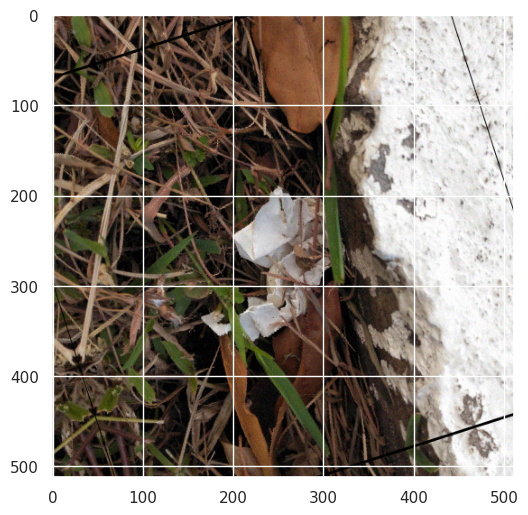

In [25]:
k = 2

cropped_images_all, proposals_all, predictions_all = edge_boxes_train([images[k]], [bboxes[k]])       
plt.imshow(images[k].detach().permute(1,2,0).cpu().numpy())

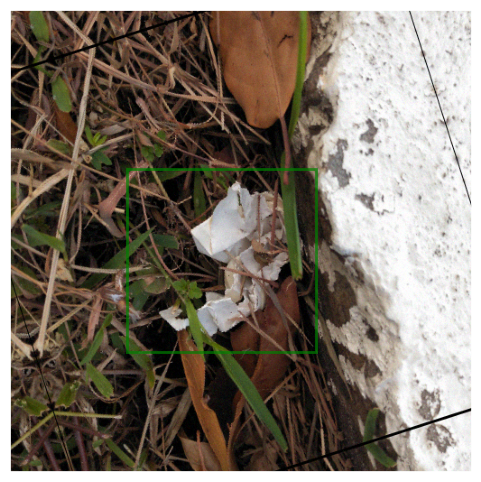

In [26]:
fig,ax = plt.subplots(1)

plt.imshow(images[k].permute(1,2,0))
plt.xticks([])
plt.yticks([])

# Show annotations
for ann in bboxes[k]:
    [x, y, x1, y1] = ann
    rect = Rectangle((x,y),x1,y1,linewidth=2,edgecolor='green',
                     facecolor='none', alpha=0.7)
    ax.add_patch(rect)
#plt.savefig(f'imgs/output_{img_idx}.png')
plt.show()

In [27]:
proposals_all

[[[195, 163, 134, 228],
  [32, 150, 328, 218],
  [147, 163, 187, 319],
  [105, 162, 225, 203],
  [100, 105, 264, 260],
  [182, 190, 181, 200],
  [193, 135, 167, 254],
  [65, 105, 265, 292],
  [164, 160, 164, 276],
  [146, 65, 183, 304],
  [15, 233, 211, 252],
  [194, 190, 191, 177],
  [190, 178, 143, 301],
  [164, 190, 253, 200],
  [19, 180, 341, 217],
  [122, 311, 163, 197],
  [89, 88, 226, 282],
  [95, 190, 271, 198],
  [144, 177, 161, 331],
  [146, 160, 157, 211],
  [68, 190, 293, 135],
  [94, 167, 209, 173],
  [95, 190, 236, 157],
  [231, 5, 155, 349],
  [138, 190, 192, 139],
  [96, 189, 189, 179],
  [127, 192, 204, 199],
  [33, 211, 354, 157],
  [146, 163, 139, 273],
  [136, 162, 179, 149],
  [205, 295, 127, 142],
  [328, 79, 83, 181],
  [77, 6, 162, 125],
  [164, 176, 119, 196],
  [123, 163, 139, 205],
  [95, 222, 236, 146],
  [23, 54, 57, 129],
  [218, 256, 116, 136],
  [66, 283, 161, 57],
  [216, 229, 101, 92],
  [354, 183, 156, 307],
  [106, 94, 99, 138],
  [178, 99, 74, 223],

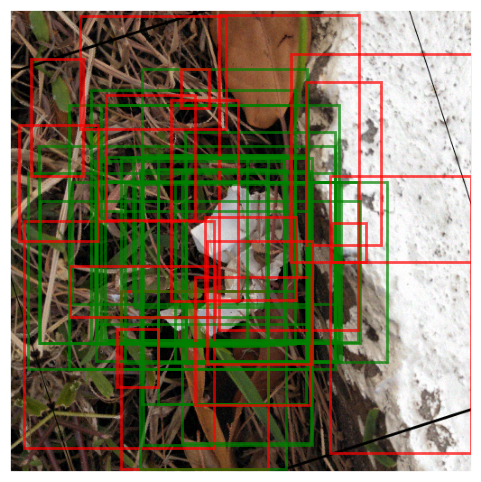

In [28]:
fig,ax = plt.subplots(1)

plt.imshow(images[k].permute(1,2,0))
plt.xticks([])
plt.yticks([])

# Show annotations
for i, ann in enumerate(proposals_all[0]):
    
    [x, y, x1, y1] = ann
    if predictions_all[i]:
        edge_col = 'green'
    else:
        edge_col = 'red'
    rect = Rectangle((x,y),x1,y1,linewidth=2,edgecolor=edge_col,
                     facecolor='none', alpha=0.7)
    ax.add_patch(rect)
#plt.savefig(f'imgs/output_{img_idx}.png')
plt.show()

In [15]:
data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)
        

/tmp/ipykernel_4699/3134758864.py:1: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  data, target = torch.stack(cropped_images_all).to(device), torch.FloatTensor(predictions_all).to(device)


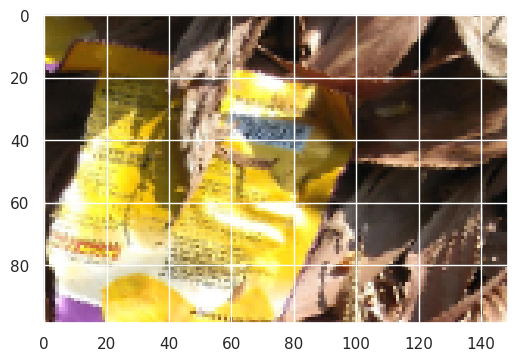

In [91]:
plt.imshow(images[k].permute(1,2,0).detach().cpu().numpy()[y:y+h, x:x+w])

In [69]:
plt.imshow(fn.crop(, x, y, w, h ))

SyntaxError: invalid syntax (2798939826.py, line 1)

In [17]:
target

tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0')

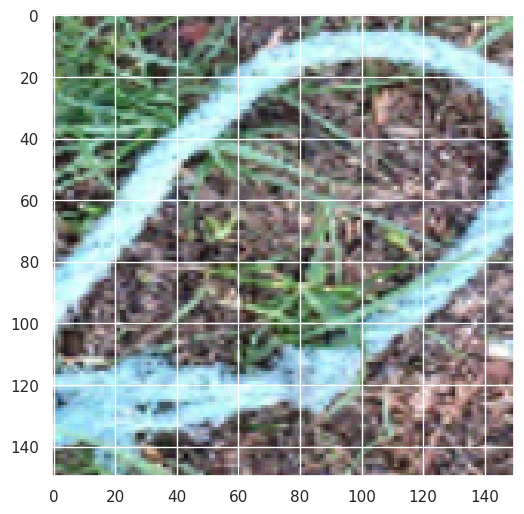

In [19]:
plt.imshow(cropped_images_all[1].detach().permute(1,2,0).cpu().numpy())

In [20]:
target

tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0')

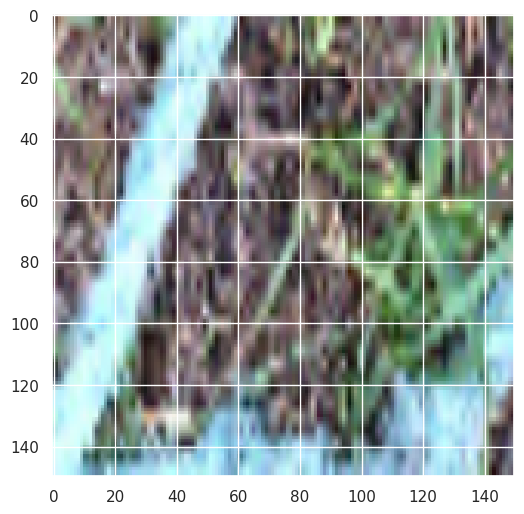

In [23]:
plt.imshow(data[3].detach().permute(1,2,0).cpu().numpy())

In [ ]:

# CNN
optimizer.zero_grad()
output = model(data)[:,0]
loss = loss_function(output, target)
loss.backward()
optimizer.step()

train_loss.append(loss.item())
predicted = output > 0.5
train_correct += (target==predicted).sum().cpu().item()
train_len += data.shape[0]
print(f'train_loss: {loss:.5f}')
# break
        

In [ ]:
optimizer.zero_grad()
output = model(data)[:,0]
        